# Short-term Stock Price Forecasting with LSTM

> This model is designed for short-term stock price predictions, utilizing a dataset that spans 1 year and employs a single-step approach. Each prediction is made based on the most recent data point available, making it particularly suited for short-term forecasting. The architecture of the model, which includes LSTM layers with dropout and regularization, is optimized to capture short-term trends and patterns within the stock market.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime
import pytz

import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping

2024-02-25 17:50:00.759451: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Collection

In [2]:
# Fetch stock data and earnings dates
def fetch_stock_data_with_earnings(ticker, period):
    try:
        stock = yf.Ticker(ticker)

        data = stock.history(period=period)
        data.index = data.index.date

        earnings = stock.earnings_dates
        earnings.index = earnings.index.date
        
        return data, earnings
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return None, None

In [3]:
# Fetch stock data
ticker = "TSLA"
period = "1y"

data, earnings = fetch_stock_data_with_earnings(ticker, period)
if data is None:
    raise ValueError("Failed to fetch stock data.")

## Merge S&P 500 Data

In [4]:
# Fetch S&P 500 historical data
sp500 = yf.Ticker("^GSPC")
sp500_data = sp500.history(period=period)
sp500_data.index = sp500_data.index.date

data_sp500 = sp500_data[['Close']] 
data_sp500.columns = ['SP500_Close']    # Rename the columns for clarity
data = data.merge(data_sp500, how='left', left_index=True, right_index=True)

data = data.drop(columns=['Dividends', 'Stock Splits']) # Drop unused columns

In [5]:
data.tail()

,Open,High,Low,Close,Volume,SP500_Close
2024-02-16,202.059998,203.169998,197.399994,199.949997,111173600,5005.569824
2024-02-20,196.130005,198.600006,189.130005,193.759995,104545800,4975.509766
2024-02-21,193.360001,199.440002,191.949997,194.770004,103844000,4981.799805
2024-02-22,194.000000,198.320007,191.360001,197.410004,92739500,5087.029785
2024-02-23,195.309998,197.570007,191.500000,191.970001,78670300,5088.799805


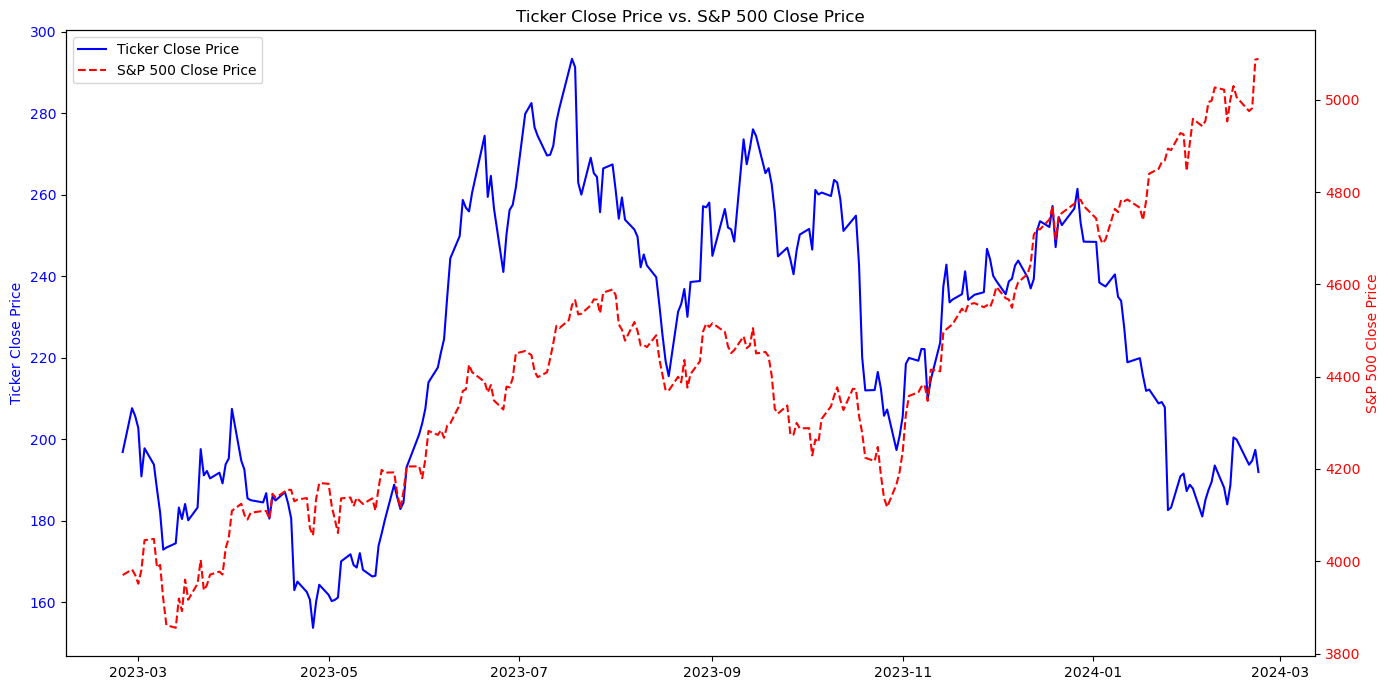

In [6]:
plt.figure(figsize=(14, 7))  # Set figure size

# Plot ticker 'Close' price with the first y-axis
ax1 = plt.gca()
line1 = ax1.plot(data.index, data['Close'], label='Ticker Close Price', color='blue')
ax1.set_ylabel('Ticker Close Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot 'SP500_Close' with the second y-axis
ax2 = ax1.twinx()
line2 = ax2.plot(data.index, data['SP500_Close'], label='S&P 500 Close Price', color='red', linestyle='--')
ax2.set_ylabel('S&P 500 Close Price', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Ticker Close Price vs. S&P 500 Close Price')
plt.xlabel('Date')

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
plt.legend(lines, labels)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
# Function to check if the current time is within trading hours
def is_trading_hours():
    eastern = pytz.timezone('US/Eastern')
    now_eastern = datetime.datetime.now(eastern)
    
    # Define market open and close times (9:30 AM to 4:00 PM)
    market_open = now_eastern.replace(hour=9, minute=30, second=0, microsecond=0)
    market_close = now_eastern.replace(hour=16, minute=0, second=0, microsecond=0)
    
    return market_open <= now_eastern <= market_close

# Drop the last row if it's within trading hours (incomplete data)
if is_trading_hours():
    print('Trading Hours.')
    data = data.drop(data.tail(1).index)
else:
    print('After Hours.')

After Hours.


## Feature Engineering


In [8]:
# EMA
short_span, long_span = 10, 50

data['EMA_Short'] = data['Close'].ewm(span=short_span, adjust=False).mean()
data['EMA_Long'] = data['Close'].ewm(span=long_span, adjust=False).mean()

# RSI
delta = data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))

# MACD
exp1 = data['Close'].ewm(span=12, adjust=False).mean()
exp2 = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = exp1 - exp2

### EMA (Exponential Moving Average)

- EMA is a type of moving average that places a greater weight and significance on the most recent data points. It is more responsive to new information compared to the SMA.
- Usage in analysis: EMA is often used to identify the direction of the trend, with prices above the EMA suggesting an uptrend and prices below indicating a downtrend. Traders might use short-term EMAs to make quick, momentum-based decisions and longer-term EMAs for overall trend direction.


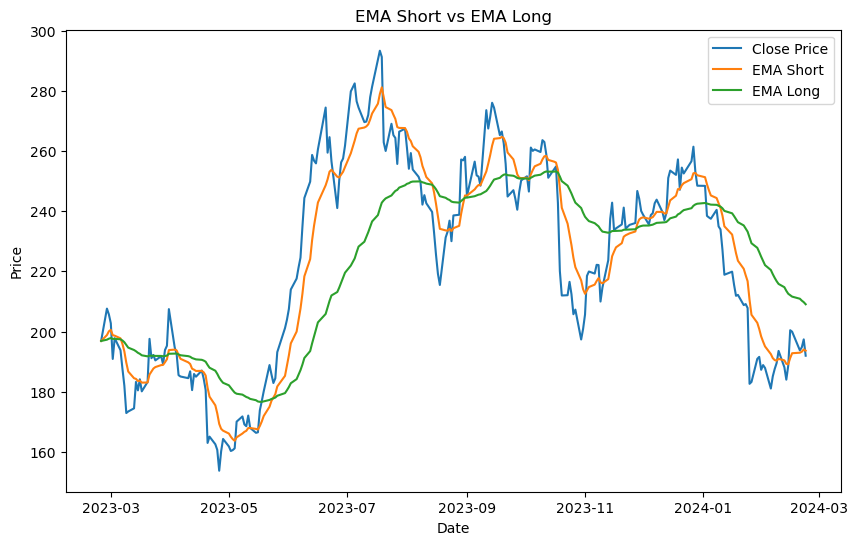

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Close'], label='Close Price')
plt.plot(data.index, data['EMA_Short'], label='EMA Short')
plt.plot(data.index, data['EMA_Long'], label='EMA Long')
plt.title('EMA Short vs EMA Long')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

### RSI (Relative Strength Index)

- RSI is a momentum oscillator that measures the speed and change of price movements on a scale of 0 to 100. It is used to identify overbought or oversold conditions in a security's price.
- Usage in analysis: Values above 70 are considered overbought (suggesting a potential sell signal), while values below 30 are considered oversold (indicating a potential buy signal). RSI can also show divergence signals, where the price trend and RSI trend move in opposite directions, suggesting a potential reversal.


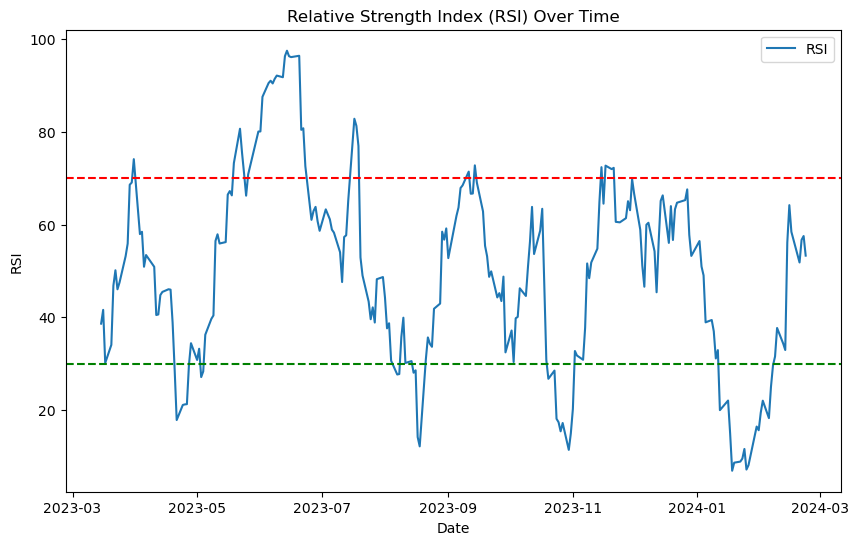

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['RSI'], label='RSI')
plt.title('Relative Strength Index (RSI) Over Time')
plt.xlabel('Date')
plt.axhline(70, linestyle='--', color='red')  # Overbought line
plt.axhline(30, linestyle='--', color='green')  # Oversold line
plt.ylabel('RSI')
plt.legend()
plt.show()

### MACD (Moving Average Convergence Divergence)

- MACD is a trend-following momentum indicator that shows the relationship between two moving averages of a security's price. It consists of the MACD line (difference between two EMAs), a signal line (EMA of the MACD line), and a histogram (difference between MACD and its signal line).
- Usage in analysis: MACD is used to identify changes in the strength, direction, momentum, and duration of a trend. A bullish crossover occurs when the MACD crosses above its signal line, suggesting a buy signal, while a bearish crossover (MACD falls below the signal line) suggests a sell signal. The divergence between the MACD and price action can also indicate potential market reversals.


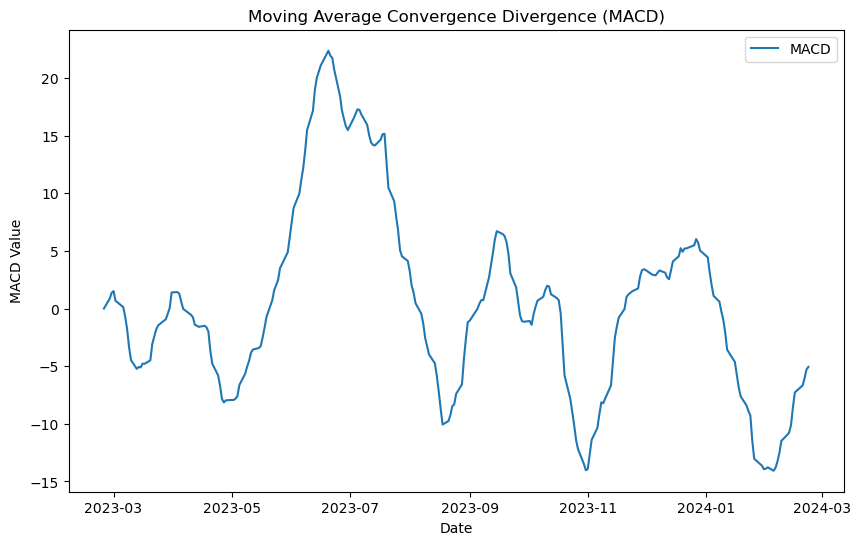

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['MACD'], label='MACD')
plt.title('Moving Average Convergence Divergence (MACD)')
plt.xlabel('Date')
plt.ylabel('MACD Value')
plt.legend()
plt.show()

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 251 entries, 2023-02-24 to 2024-02-23
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         251 non-null    float64
 1   High         251 non-null    float64
 2   Low          251 non-null    float64
 3   Close        251 non-null    float64
 4   Volume       251 non-null    int64  
 5   SP500_Close  251 non-null    float64
 6   EMA_Short    251 non-null    float64
 7   EMA_Long     251 non-null    float64
 8   RSI          238 non-null    float64
 9   MACD         251 non-null    float64
dtypes: float64(9), int64(1)
memory usage: 29.7+ KB


In [13]:
earnings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12 entries, 2025-01-22 to 2022-04-20
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   EPS Estimate  9 non-null      float64
 1   Reported EPS  8 non-null      float64
 2   Surprise(%)   8 non-null      float64
dtypes: float64(3)
memory usage: 384.0+ bytes


## Data Preprocessing


In [14]:
# Splitting data into features and labels
features = data.drop(columns=['Close'])
target = data[['Close']]

In [15]:
# Scaling
feature_scaler = MinMaxScaler(feature_range=(0, 1))
features= features.bfill()
scaled_features = feature_scaler.fit_transform(features)

target_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = target_scaler.fit_transform(target)


# Convert scaled data back to DataFrame for further processing
scaled_features_df = pd.DataFrame(scaled_features, index=data.index, columns=features.columns)
scaled_target_df = pd.DataFrame(scaled_target, index=data.index, columns=target.columns)

## Merge earnings data


In [16]:
# Merge earnings data
scaled_features_df = scaled_features_df.merge(earnings, how='left', left_index=True, right_index=True)
scaled_features_df = scaled_features_df.fillna(method='ffill').fillna(method='bfill')

# Display the merged dataframe
scaled_features_df

/var/folders/hd/pv9sg75d6b38kvxtq9c67bw40000gn/T/ipykernel_22248/2796264541.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  scaled_features_df = scaled_features_df.fillna(method='ffill').fillna(method='bfill')


,Open,High,Low,Volume,SP500_Close,EMA_Short,EMA_Long,RSI,MACD,EPS Estimate,Reported EPS,Surprise(%)
2023-02-24,0.304672,0.267920,0.294787,0.525683,0.092682,0.282480,0.264176,0.350206,0.386067,0.85,0.85,-0.0004
2023-02-27,0.344421,0.352568,0.356471,0.653861,0.102576,0.299116,0.269681,0.350206,0.409591,0.85,0.85,-0.0004
2023-02-28,0.404114,0.365608,0.374626,0.600113,0.092771,0.309757,0.273986,0.350206,0.423552,0.85,0.85,-0.0004
2023-03-01,0.373570,0.336575,0.336493,0.625393,0.077556,0.313912,0.276618,0.350206,0.427630,0.85,0.85,-0.0004
2023-03-02,0.237796,0.239680,0.245279,0.793441,0.101854,0.298943,0.273068,0.350206,0.404375,0.85,0.85,-0.0004
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-16,0.344630,0.307543,0.328327,0.313955,0.932500,0.247752,0.456542,0.568797,0.186607,0.74,0.71,-0.0439
2024-02-20,0.303278,0.274620,0.268028,0.268767,0.908121,0.249238,0.447401,0.495796,0.202909,0.74,0.71,-0.0439
2024-02-21,0.283961,0.280671,0.288589,0.263982,0.913223,0.252017,0.439135,0.549739,0.219979,0.74,0.71,-0.0439
2024-02-22,0.288424,0.272603,0.284287,0.188273,0.998565,0.258376,0.432545,0.558761,0.241023,0.74,0.71,-0.0439


In [17]:
scaled_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 251 entries, 2023-02-24 to 2024-02-23
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          251 non-null    float64
 1   High          251 non-null    float64
 2   Low           251 non-null    float64
 3   Volume        251 non-null    float64
 4   SP500_Close   251 non-null    float64
 5   EMA_Short     251 non-null    float64
 6   EMA_Long      251 non-null    float64
 7   RSI           251 non-null    float64
 8   MACD          251 non-null    float64
 9   EPS Estimate  251 non-null    float64
 10  Reported EPS  251 non-null    float64
 11  Surprise(%)   251 non-null    float64
dtypes: float64(12)
memory usage: 33.6+ KB


## Training


In [18]:
test_size = 30 # Number of samples to be used for testing

training_features = scaled_features_df[:-test_size]
training_target = scaled_target_df[:-test_size] 

test_features = scaled_features_df[-test_size:]
test_target = scaled_target_df[-test_size:]

print('training', len(training_features), len(training_target))
print('testing', len(test_features), len(test_target))

training 221 221
testing 30 30


In [19]:
# Model parameters

num_layers = 1
size_layer = 100
epochs = 20
dropout_rate = 0.2
reg_rate = 0.0001
batch_size = 5

In [20]:
# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# LSTM model with l1_l2 Regularization and Dropout
def build_model(input_shape, num_layers=2, size_layer=128, dropout_rate=0.2, reg_rate=0.01):
    model = Sequential()
    reg = l1_l2(l1=reg_rate, l2=reg_rate)

    for i in range(num_layers):
        return_sequences = i < num_layers - 1
        model.add(Bidirectional(LSTM(size_layer, return_sequences=return_sequences, kernel_regularizer=reg), input_shape=input_shape))
        
        if return_sequences:
            model.add(Dropout(dropout_rate))
    
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mean_squared_error') # adagrad
    
    return model

# Setup early stopping to avoid overfitting
early_stopping = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)

In [21]:
best_val_loss = np.inf
best_model = None
best_history = None


# Cross-validate using TimeSeriesSplit
for train_index, val_index in tscv.split(training_features):
    X_train, X_val = training_features.iloc[train_index], training_features.iloc[val_index]
    y_train, y_val = training_target.iloc[train_index], training_target.iloc[val_index]

    # Reshape input for LSTM [samples, time steps, features]
    X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_val = X_val.values.reshape((X_val.shape[0], 1, X_val.shape[1]))

    # Create and fit the LSTM model
    model = build_model(input_shape=(X_train.shape[1], X_train.shape[2]),
                        num_layers=num_layers,
                        size_layer=size_layer,
                        dropout_rate=dropout_rate,
                        reg_rate=reg_rate,
                        )

    # Fit the model with Early Stopping
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(
        X_val, y_val), callbacks=[early_stopping], verbose=1)
    
    # Track the best model based on validation loss
    val_loss = np.min(history.history['val_loss'])
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        best_history = history

Epoch 1/20
9/9 [==============================] - 4s 109ms/step - loss: 0.0902 - val_loss: 0.0797
Epoch 2/20
9/9 [==============================] - 0s 7ms/step - loss: 0.0608 - val_loss: 0.0719
Epoch 3/20
9/9 [==============================] - 0s 8ms/step - loss: 0.0547 - val_loss: 0.0644
Epoch 4/20
9/9 [==============================] - 0s 7ms/step - loss: 0.0462 - val_loss: 0.0604
Epoch 5/20
9/9 [==============================] - 0s 7ms/step - loss: 0.0414 - val_loss: 0.0533
Epoch 6/20
9/9 [==============================] - 0s 7ms/step - loss: 0.0361 - val_loss: 0.0463
Epoch 7/20
9/9 [==============================] - 0s 7ms/step - loss: 0.0317 - val_loss: 0.0418
Epoch 8/20
9/9 [==============================] - 0s 9ms/step - loss: 0.0276 - val_loss: 0.0391
Epoch 9/20
9/9 [==============================] - 0s 7ms/step - loss: 0.0243 - val_loss: 0.0332
Epoch 10/20
9/9 [==============================] - 0s 7ms/step - loss: 0.0209 - val_loss: 0.0293
Epoch 11/20
9/9 [====================

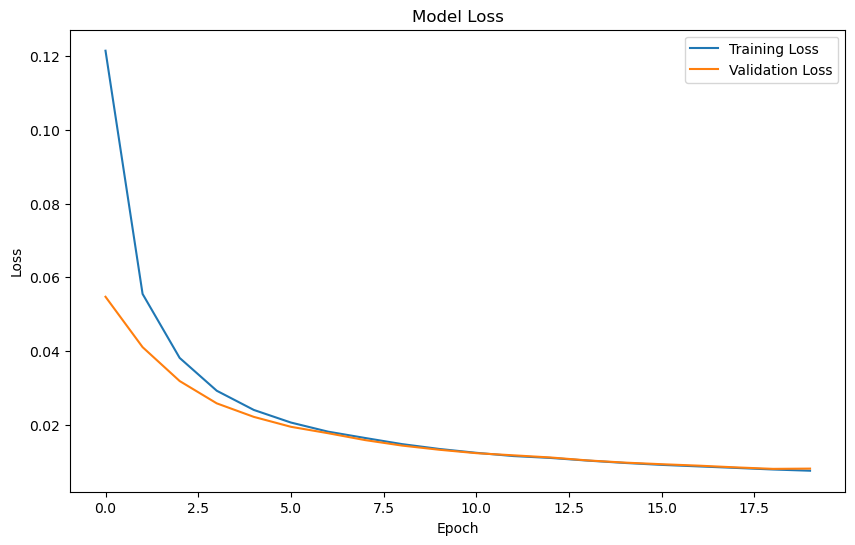

In [22]:
# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(best_history.history['loss'], label='Training Loss')
plt.plot(best_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
# Use the best model from cross-validation
X_final_train = training_features.values.reshape((training_features.shape[0], 1, training_features.shape[1]))
y_final_train = training_target

# Re-train the best model on the entire training dataset (excluding the final validation set)
best_model.fit(X_final_train, y_final_train, epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/20
45/45 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 2/20
45/45 [==============================] - 0s 4ms/step - loss: 0.0070
Epoch 3/20
45/45 [==============================] - 0s 2ms/step - loss: 0.0062
Epoch 4/20
45/45 [==============================] - 0s 2ms/step - loss: 0.0060
Epoch 5/20
45/45 [==============================] - 0s 2ms/step - loss: 0.0056
Epoch 6/20
45/45 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch 7/20
45/45 [==============================] - 0s 2ms/step - loss: 0.0050
Epoch 8/20
45/45 [==============================] - 0s 2ms/step - loss: 0.0047
Epoch 9/20
45/45 [==============================] - 0s 2ms/step - loss: 0.0045
Epoch 10/20
45/45 [==============================] - 0s 2ms/step - loss: 0.0043
Epoch 11/20
45/45 [==============================] - 0s 2ms/step - loss: 0.0041
Epoch 12/20
45/45 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 13/20
45/45 [==============================

## Testing


In [24]:
# Prepare the test data
X_test = test_features.values.reshape((test_features.shape[0], 1, test_features.shape[1]))

# Make predictions on the test data
test_predictions = best_model.predict(X_test)

# Inverse transform the predictions and actual values to their original scale
predictions = target_scaler.inverse_transform(test_predictions)
actual = target_scaler.inverse_transform(test_target)

1/1 [==============================] - 1s 1s/step


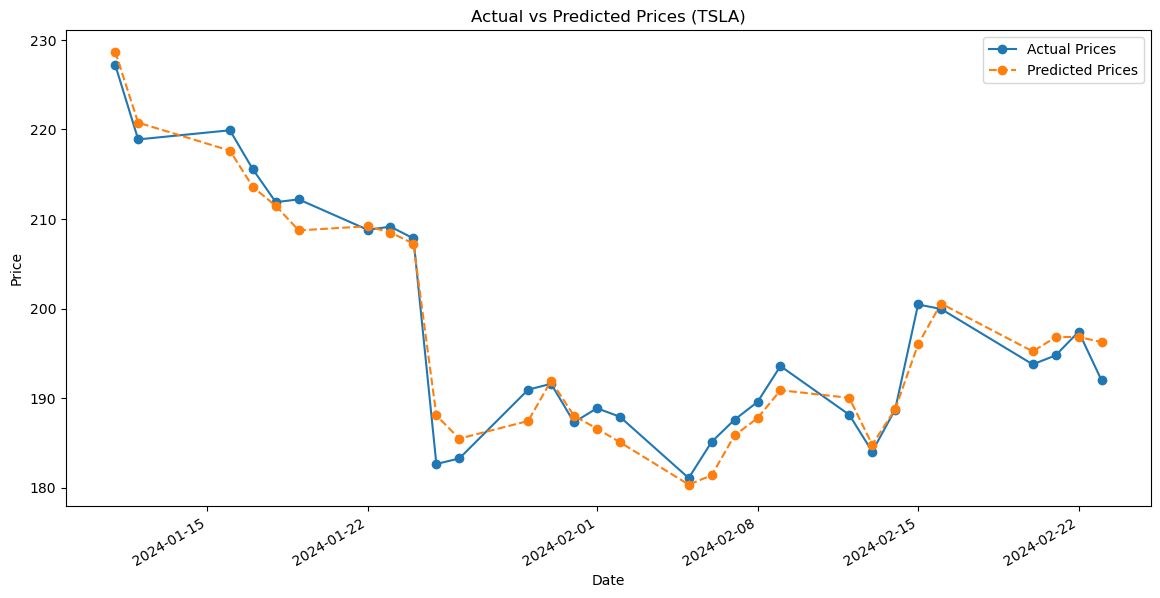

In [25]:
# Plot predictions
def plot_predictions(predictions, actual, dates, title=f'Actual vs Predicted Prices ({ticker})'):
    plt.figure(figsize=(14, 7))
    plt.plot(dates, actual, label='Actual Prices', marker='o')  # Use test_target's index for actual prices
    plt.plot(dates, predictions, label='Predicted Prices', linestyle='--', marker='o')  # Use the same index for predictions
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()

    plt.xticks(rotation=45)  # Rotate date labels for better readability
    plt.gcf().autofmt_xdate() 
    
    plt.show()

plot_predictions(predictions, actual, test_target.index)

## Score


In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Calculate evaluation metrics
mse = mean_squared_error(actual, predictions)
mae = mean_absolute_error(actual, predictions)
rmse = np.sqrt(mse)

r2 = r2_score(actual, predictions)

# Adjusted R-squared
n = test_size  # Number of observations
p = len(features.columns)   # Number of predictors
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

mape = mean_absolute_percentage_error(actual, predictions)

print("Mean Squared Error (MSE):", round(mse, 2))
print("Mean Absolute Error (MAE):", round(mae, 2))
print("Root Mean Squared Error (RMSE):", round(rmse, 2))
print("R-squared (R2):", round(r2, 2))
print("Adjusted R-squared:", round(adj_r2, 2))
print("Mean Absolute Percentage Error (MAPE):", round(mape, 2))

Mean Squared Error (MSE): 5.52
Mean Absolute Error (MAE): 1.91
Root Mean Squared Error (RMSE): 2.35
R-squared (R2): 0.97
Adjusted R-squared: 0.95
Mean Absolute Percentage Error (MAPE): 0.01


### Mean Squared Error (MSE) and Mean Absolute Error (MAE):

- These metrics measure the average error between the predicted and actual values.
- Lower values indicate better performance.
- However, the absolute scale of these metrics is dependent on the scale of your target variable. Therefore, it's difficult to define a universally "good" threshold. It's more informative to compare these metrics across different models or variations of your LSTM model.

### Root Mean Squared Error (RMSE):

- RMSE is in the same units as the target variable, which can make it more interpretable.
- Similar to MSE and MAE, lower values are desirable.
- Like MSE and MAE, it's more useful for comparing models rather than establishing absolute thresholds.

### R-squared (R2) and Adjusted R-squared:

- R2 measures the proportion of the variance in the dependent variable that is predictable from the independent variables.
- R2 ranges from 0 to 1, with higher values indicating better fit.
- A value of 1 indicates that the model explains all the variability of the response data around its mean. However, a high R2 value doesn't necessarily mean a good model, as it may overfit.
- Adjusted R-squared adjusts the R2 value based on the number of predictors in the model, providing a more accurate measure of model performance, especially with multiple variables.
- Generally, R2 values closer to 1 and higher Adjusted R-squared values are desirable, but the interpretation depends on the context and the complexity of the model.

### Mean Absolute Percentage Error (MAPE):

- MAPE measures the average absolute percentage difference between predicted and actual values.
- Lower values indicate better performance.
- A MAPE of 0% indicates a perfect fit, but in practice, it's rare to achieve such a value.
- It's common to interpret MAPE in the context of the variability of the target variable. For example, a MAPE below 10% might be considered good in some domains.


## Prediction


In [27]:
# Function to predict future 'n' days
def predict_future_days(model, last_input, feature_scaler, target_scaler, n_days):
    future_predictions_scaled = []
    input_sequence = last_input.copy()  # Copy the last known input sequence

    # Iteratively predict the next 'n' days
    for _ in range(n_days):
        # Reshape input for model prediction [samples, time steps, features]
        reshaped_input = input_sequence.reshape((1, 1, input_sequence.shape[1]))

        # Predict the next day
        next_day_prediction_scaled = model.predict(reshaped_input)

        # Store the scaled prediction
        future_predictions_scaled.append(next_day_prediction_scaled[0, 0])

        # Prepare the next input sequence for prediction
        next_input_sequence = np.append(input_sequence[:, 1:], next_day_prediction_scaled, axis=1)
        input_sequence = next_input_sequence

    # Reshape the predictions to fit the target_scaler inverse transform
    future_predictions_scaled = np.array(future_predictions_scaled).reshape(-1, 1)

    # Inverse transform to get predictions in original scale
    future_predictions = target_scaler.inverse_transform(future_predictions_scaled)[:, 0]
    
    return future_predictions

# Predict future 'n' days
n_days = 5  # Number of days to predict
last_known_input = scaled_features_df.iloc[-1:].values  # Use the last known input features

future_predictions = predict_future_days(best_model, last_known_input, feature_scaler, target_scaler, n_days)

1/1 [==============================] - 0s 23ms/step


In [28]:
future_predictions

array([196.24324, 188.95062, 226.68204, 221.45973, 215.88591],
      dtype=float32)

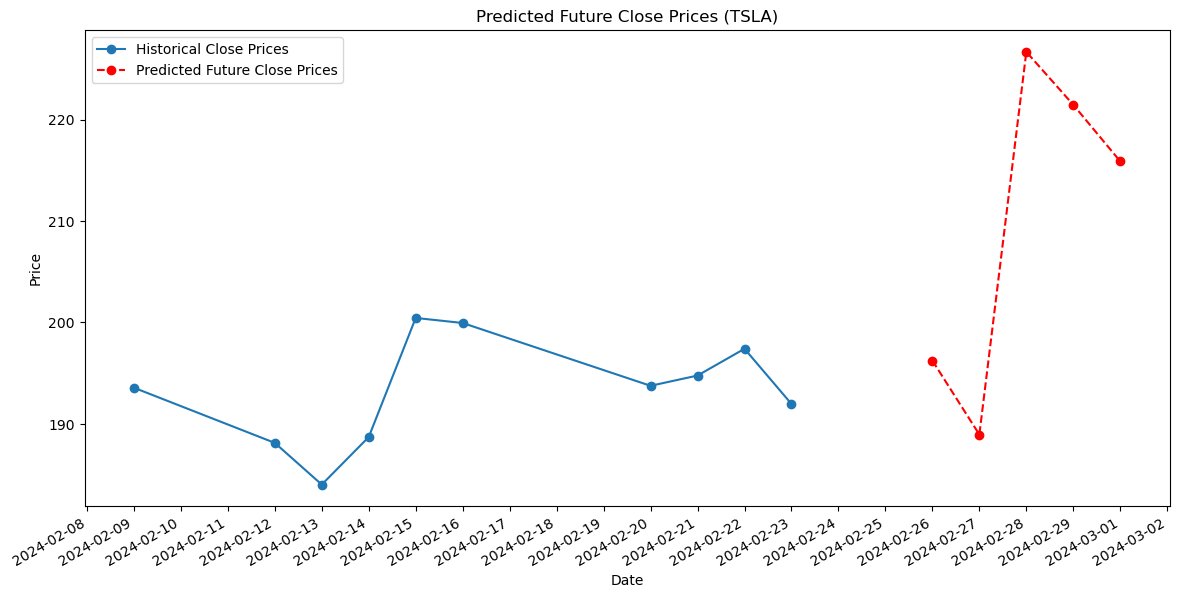

In [29]:
import matplotlib.dates as mdates

# Function to generate future dates excluding weekends
def generate_future_weekdays(start_date, n_days):
    future_dates = []
    current_date = start_date
    while len(future_dates) < n_days:
        current_date += datetime.timedelta(days=1)
        # Check if current_date is a weekday (Monday=0, Sunday=6)
        if current_date.weekday() < 5:  # Weekdays are 0-4
            future_dates.append(current_date)
    return future_dates

# Historical data
historical_dates = data.index[-10:]  # Last 20 days from the historical data
historical_prices = data['Close'][-10:]

# Generate future weekday dates for predictions
last_date = datetime.datetime.strptime(str(historical_dates[-1]), '%Y-%m-%d')
future_weekday_dates = generate_future_weekdays(last_date, n_days)

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(historical_dates, historical_prices, label='Historical Close Prices', marker='o')
plt.plot(future_weekday_dates, future_predictions, label='Predicted Future Close Prices', linestyle='--', marker='o', color='red')

plt.title(f'Predicted Future Close Prices ({ticker})')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.xticks(rotation=45)

plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate() 

plt.show()

Here's the refactored explanation to match your updated code:

## Future Price Prediction Explanation

The future price prediction in this model leverages a function that iteratively forecasts prices for a specified number of days ahead, utilizing the most recent input data. This approach is particularly pertinent for predicting stock prices where future values (like the next day's 'Open', 'High', 'Low') are unknown.

### Preparing the Last Known Input

The prediction process commences with the preparation of the last known input data, which is the most recent data point available from the dataset. This last input is crucial as it serves as the starting point for future predictions. The code snippet for this preparation is:

```python
last_known_input = scaled_features_df.iloc[-1:].values  # Use the last known input features
```

Here, `scaled_features_df.iloc[-1:]` fetches the last row of the scaled feature dataset, representing the most recent day's data.

### Iterative Future Prediction

The essence of the future price prediction lies in an iterative mechanism where each prediction is subsequently used as input for the next. This iterative forecasting is encapsulated in the `predict_future_days` function:

```python
def predict_future_days(model, last_input, feature_scaler, target_scaler, n_days):
    future_predictions_scaled = []
    input_sequence = last_input.copy()  # Copy the last known input sequence

    for _ in range(n_days):
        reshaped_input = input_sequence.reshape((1, 1, input_sequence.shape[1]))
        next_day_prediction_scaled = model.predict(reshaped_input)
        future_predictions_scaled.append(next_day_prediction_scaled[0, 0])
        next_input_sequence = np.append(input_sequence[:, 1:], next_day_prediction_scaled, axis=1)
        input_sequence = next_input_sequence

    future_predictions_scaled = np.array(future_predictions_scaled).reshape(-1, 1)
    future_predictions = target_scaler.inverse_transform(future_predictions_scaled)[:, 0]

    return future_predictions
```

In this function:

- `input_sequence` starts as the last known input, and with each iteration, the model predicts the next day's price.
- The prediction (`next_day_prediction_scaled`) is appended to `future_predictions_scaled`, accumulating the future price predictions.
- `input_sequence` is updated with the new prediction, effectively simulating the input for the next day's prediction.
- After completing the predictions for the desired number of days, the `future_predictions` are inversely transformed to the original price scale using the `target_scaler`.

### Conclusion

This iterative prediction method allows for forecasting future stock prices based on historical data patterns. However, it's crucial to recognize that the accuracy of these predictions may diminish over time due to the cumulative effect of prediction errors and the absence of actual future inputs. This strategy presupposes that historical trends will persist, which may not always be the case in the volatile stock market environment.
